<a href="https://colab.research.google.com/github/bathanh0309/dl_VNnews_LSTM_multilayer/blob/main/Cau2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Câu 2. Hai file "train_02.csv" và "test_02.csv" chứa dữ liệu văn bản dùng cho bài toán phân loại chủ đề tin tức (News topic classification). Mỗi dòng trong mỗi file gồm hai cột: chỉ số loại chủ đề (class index) và mô tả (description).

Chỉ số loại chủ để gồm: 1-Thế giới (World), 2-Thể thao (Sports), 3-Kinh doanh (Business), 4-Khoa học & Cong nghệ (Science and Technology).
Sinh viên thực hiện và báo cáo các nội dung sau:

a. Xây dựng một bộ phân loại sử dụng nhiều lớp LSTM cùng các lớp khác để xác định 4 loại chủ
đề tin tức. Liệt kê và mô tả tất cả các lớp trong mô hình, bao gồm: tên lớp, hàm kích hoạt. Đối với các lớp LSTM, cần mô tả số timestep và kích thước vector đầu vào. Giải thích lý do lựa chọn cấu trúc mô hình.

b. Trong báo cáo, mô tả chi tiết các bước xử lý dữ liệu (input, labels). Mô tả dữ liệu đầu vào của

mô hình phân loại sau khi xử lý.

c. Trong code, hiển thị số lượng tham số của từng lớp trong mô hình và báo cáo kết quả.

d. Trình bày hàm mất mát, thuật toán tối ưu hóa, và learning rate mà sinh viên đã chọn. Giải thích lý do lựa chọn. Huấn luyện mô hình ít nhất 10 vòng lặp (iterations). Sau khi huấn luyện, trình bày và nhận xét kết quả train và test mà sinh viên đạt được.

e. Nêu ưu và nhược điểm của mô hình sinh viên đã sử dụng. Đề xuất giải pháp cải thiện kết quả.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 1: Import thư viện
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Cài đặt seed để tái hiện kết quả
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


Mounted at /content/drive
THÔNG TIN DỮ LIỆU

Kích thước train: (120000, 2)
Kích thước test: (7600, 2)

5 dòng đầu train:
   class_index                                        description
0            3  Reuters - Short-sellers, Wall Street's dwindli...
1            3  Reuters - Private investment firm Carlyle Grou...
2            3  Reuters - Soaring crude prices plus worries\ab...
3            3  Reuters - Authorities have halted oil export\f...
4            3  AFP - Tearaway world oil prices, toppling reco...

Phân bố class trong train:
class_index
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64

Phân bố class trong test:
class_index
1    1900
2    1900
3    1900
4    1900
Name: count, dtype: int64


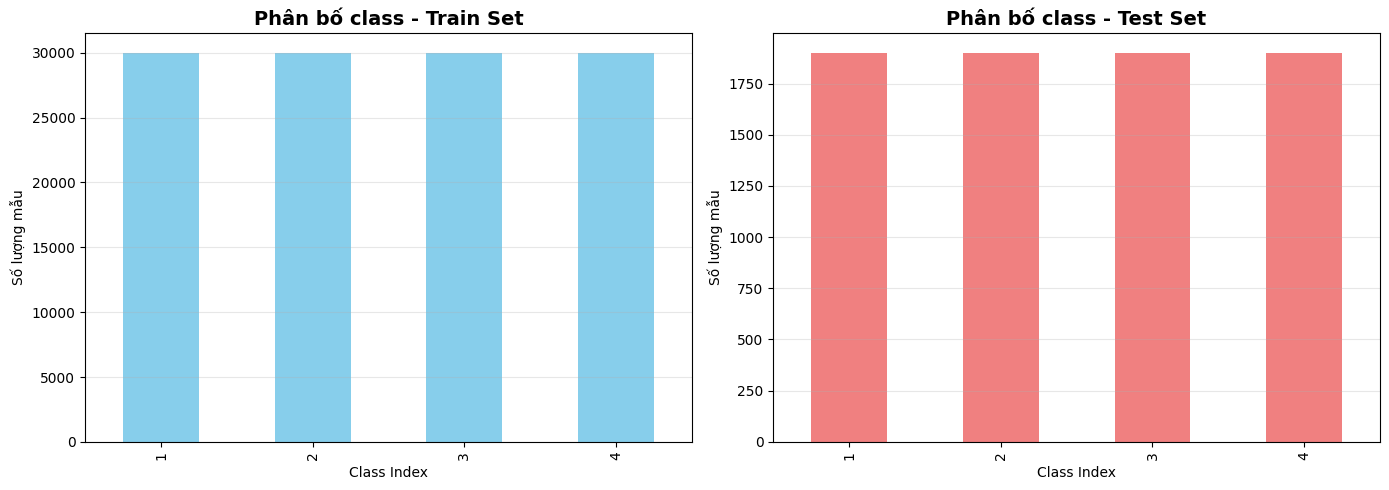


➤ Dataset tương đối cân bằng giữa các class, phù hợp cho training.


In [ ]:
# Cell 2: Mount Google Drive và đọc dữ liệu
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/deeplearning_final/train_02.csv"
test_path = "/content/drive/MyDrive/deeplearning_final/test_02.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Đổi tên cột
train_df = train_df.rename(columns={
    "Class Index": "class_index",
    "Description": "description"
})
test_df = test_df.rename(columns={
    "Class Index": "class_index",
    "Description": "description"
})

print("=" * 80)
print("THÔNG TIN DỮ LIỆU")
print("=" * 80)
print(f"\nKích thước train: {train_df.shape}")
print(f"Kích thước test: {test_df.shape}")

print("\n5 dòng đầu train:")
print(train_df.head())

print("\nPhân bố class trong train:")
print(train_df['class_index'].value_counts().sort_index())

print("\nPhân bố class trong test:")
print(test_df['class_index'].value_counts().sort_index())

# Vẽ biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df['class_index'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Phân bố class - Train Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Số lượng mẫu')
axes[0].grid(axis='y', alpha=0.3)

test_df['class_index'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Phân bố class - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class Index')
axes[1].set_ylabel('Số lượng mẫu')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n➤ Dataset tương đối cân bằng giữa các class, phù hợp cho training.")

In [ ]:
# Cell 3: Xử lý nhãn
# Chuyển class_index từ 1-4 về 0-3 cho PyTorch
train_df['label'] = train_df['class_index'] - 1
test_df['label'] = test_df['class_index'] - 1

# Mapping tên class
class_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science & Technology"
}

NUM_CLASSES = 4

print("=" * 80)
print("XỬ LÝ NHÃN")
print("=" * 80)
print("\nMapping class_index → label:")
print("class_index 1 (World) → label 0")
print("class_index 2 (Sports) → label 1")
print("class_index 3 (Business) → label 2")
print("class_index 4 (Science & Technology) → label 3")

print(f"\nMin/Max class_index train: {train_df['class_index'].min()} - {train_df['class_index'].max()}")
print(f"Min/Max label train: {train_df['label'].min()} - {train_df['label'].max()}")
print(f"Min/Max class_index test: {test_df['class_index'].min()} - {test_df['class_index'].max()}")
print(f"Min/Max label test: {test_df['label'].min()} - {test_df['label'].max()}")

print("\n➤ PyTorch CrossEntropyLoss yêu cầu nhãn từ 0 đến N-1, nên chuyển 1-4 về 0-3.")

XỬ LÝ NHÃN

Mapping class_index → label:
class_index 1 (World) → label 0
class_index 2 (Sports) → label 1
class_index 3 (Business) → label 2
class_index 4 (Science & Technology) → label 3

Min/Max class_index train: 1 - 4
Min/Max label train: 0 - 3
Min/Max class_index test: 1 - 4
Min/Max label test: 0 - 3

➤ PyTorch CrossEntropyLoss yêu cầu nhãn từ 0 đến N-1, nên chuyển 1-4 về 0-3.


In [ ]:
# Cell 4: Xử lý văn bản & xây dựng từ vựng
def preprocess_text(text):
    """Tiền xử lý văn bản"""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize(text):
    """Tách từ theo khoảng trắng"""
    return text.split()

# Áp dụng preprocessing
train_df['processed_text'] = train_df['description'].apply(preprocess_text)
test_df['processed_text'] = test_df['description'].apply(preprocess_text)

print("=" * 80)
print("XỬ LÝ VĂN BẢN")
print("=" * 80)
print("\nVí dụ text gốc:")
print(train_df['description'].iloc[0][:200])
print("\nSau khi xử lý:")
print(train_df['processed_text'].iloc[0][:200])

# Xây dựng từ vựng từ train set
print("\n" + "=" * 80)
print("XÂY DỰNG TỪ VỰNG")
print("=" * 80)

all_tokens = []
for text in train_df['processed_text']:
    all_tokens.extend(tokenize(text))

token_counts = Counter(all_tokens)
print(f"\nTổng số token trong train: {len(all_tokens):,}")
print(f"Số token khác nhau: {len(token_counts):,}")

# Special tokens
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
VOCAB_SIZE = 20000

# Lấy top words
most_common = token_counts.most_common(VOCAB_SIZE - 2)
vocab_words = [PAD_TOKEN, UNK_TOKEN] + [word for word, _ in most_common]

word2idx = {word: idx for idx, word in enumerate(vocab_words)}
idx2word = {idx: word for word, idx in word2idx.items()}

PAD_IDX = word2idx[PAD_TOKEN]
UNK_IDX = word2idx[UNK_TOKEN]

print(f"\nKích thước từ vựng cuối cùng: {len(word2idx):,}")
print(f"PAD_TOKEN: '{PAD_TOKEN}' → index {PAD_IDX}")
print(f"UNK_TOKEN: '{UNK_TOKEN}' → index {UNK_IDX}")

print("\n10 từ đầu tiên trong từ vựng:")
for i in range(10):
    print(f"  {idx2word[i]:<15} → {i}")

print("\n➤ Giới hạn vocab tránh overfitting và giảm số parameters. <pad> dùng cho padding, <unk> cho từ không có trong vocab.")


XỬ LÝ VĂN BẢN

Ví dụ text gốc:
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Sau khi xử lý:
reuters short sellers wall street s dwindling band of ultra cynics are seeing green again

XÂY DỰNG TỪ VỰNG

Tổng số token trong train: 3,751,384
Số token khác nhau: 57,817

Kích thước từ vựng cuối cùng: 20,000
PAD_TOKEN: '<pad>' → index 0
UNK_TOKEN: '<unk>' → index 1

10 từ đầu tiên trong từ vựng:
  <pad>           → 0
  <unk>           → 1
  the             → 2
  a               → 3
  to              → 4
  of              → 5
  in              → 6
  and             → 7
  s               → 8
  on              → 9

➤ Giới hạn vocab tránh overfitting và giảm số parameters. <pad> dùng cho padding, <unk> cho từ không có trong vocab.


In [ ]:
# Cell 5: Mã hóa câu & padding
MAX_LEN = 60

def encode_text(text, word2idx, max_len):
    """Mã hóa text thành sequence of indices"""
    tokens = tokenize(text)
    indices = [word2idx.get(token, UNK_IDX) for token in tokens]

    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices = indices + [PAD_IDX] * (max_len - len(indices))

    return indices

# Áp dụng encoding
train_df['encoded'] = train_df['processed_text'].apply(
    lambda x: encode_text(x, word2idx, MAX_LEN)
)
test_df['encoded'] = test_df['processed_text'].apply(
    lambda x: encode_text(x, word2idx, MAX_LEN)
)

print("=" * 80)
print("MÃ HÓA CÂU & PADDING")
print("=" * 80)
print(f"\nMax sequence length: {MAX_LEN}")
print(f"\nVí dụ mã hóa câu đầu tiên:")
print(f"Text gốc: {train_df['processed_text'].iloc[0][:100]}...")
print(f"Encoded (10 phần tử đầu): {train_df['encoded'].iloc[0][:10]}")
print(f"Độ dài sequence: {len(train_df['encoded'].iloc[0])}")
print(f"\n➤ Input của LSTM có shape (batch_size, {MAX_LEN}), mỗi index là 1 từ trong vocab.")


MÃ HÓA CÂU & PADDING

Max sequence length: 60

Ví dụ mã hóa câu đầu tiên:
Text gốc: reuters short sellers wall street s dwindling band of ultra cynics are seeing green again...
Encoded (10 phần tử đầu): [27, 726, 7536, 419, 327, 8, 10087, 2738, 5, 5693]
Độ dài sequence: 60

➤ Input của LSTM có shape (batch_size, 60), mỗi index là 1 từ trong vocab.


In [ ]:
# Cell 6: Chia train/val/test & Dataset/DataLoader
# Chia train/val
train_texts = train_df['encoded'].tolist()
train_labels = train_df['label'].tolist()

train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

test_texts = test_df['encoded'].tolist()
test_labels = test_df['label'].tolist()

print("=" * 80)
print("CHIA DỮ LIỆU")
print("=" * 80)
print(f"\nTrain samples: {len(train_texts_split):,}")
print(f"Val samples: {len(val_texts_split):,}")
print(f"Test samples: {len(test_texts):,}")

# Dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.LongTensor(self.texts[idx]),
            'label': torch.LongTensor([self.labels[idx]])[0]
        }

train_dataset = NewsDataset(train_texts_split, train_labels_split)
val_dataset = NewsDataset(val_texts_split, val_labels_split)
test_dataset = NewsDataset(test_texts, test_labels)

# DataLoader
BATCH_SIZE = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Số batch train: {len(train_loader)}")
print(f"Số batch val: {len(val_loader)}")
print(f"Số batch test: {len(test_loader)}")

# Kiểm tra 1 batch
sample_batch = next(iter(train_loader))
print(f"\nShape của 1 batch:")
print(f"  input_ids: {sample_batch['input_ids'].shape}  # (batch_size={BATCH_SIZE}, max_len={MAX_LEN})")
print(f"  labels: {sample_batch['label'].shape}        # (batch_size={BATCH_SIZE},)")


CHIA DỮ LIỆU

Train samples: 96,000
Val samples: 24,000
Test samples: 7,600

Batch size: 128
Số batch train: 750
Số batch val: 188
Số batch test: 60

Shape của 1 batch:
  input_ids: torch.Size([128, 60])  # (batch_size=128, max_len=60)
  labels: torch.Size([128])        # (batch_size=128,)


In [ ]:
# Cell 7: Kiến trúc model - Multi-layer BiLSTM
EMBEDDING_DIM = 100 #giảm từ 128
HIDDEN_DIM = 192    #giảm từ 192
NUM_LAYERS = 1      #giảm từ 2, đơn giản hóa
DROPOUT_RATE = 0.3  #giảm từ 0.5, ít regularization

class NewsLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout_rate, pad_idx):
        super(NewsLSTMClassifier, self).__init__()

        # Embedding layer: chuyển word index → dense vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Multi-layer Bidirectional LSTM
        # input: (batch, seq_len, embedding_dim)
        # output: (batch, seq_len, hidden_dim * 2) vì bidirectional
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Classification head
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, max_len)
        embedded = self.embedding(x)  # (batch_size, max_len, embedding_dim)

        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, max_len, hidden_dim*2)

        # Lấy output của timestep cuối cùng
        last_hidden = lstm_out[:, -1, :]  # (batch_size, hidden_dim*2)

        # Classification layers
        out = self.fc1(last_hidden)  # (batch_size, 128)
        out = self.relu(out)
        out = self.dropout(out)
        logits = self.fc_out(out)  # (batch_size, num_classes)

        return logits

model = NewsLSTMClassifier(
    vocab_size=len(word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
    pad_idx=PAD_IDX
).to(device)

print("=" * 80)
print("KIẾN TRÚC MODEL - MULTI-LAYER BiLSTM")
print("=" * 80)
print(f"\nHyperparameters:")
print(f"  Vocab size: {len(word2idx):,}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Num classes: {NUM_CLASSES}")
print(f"  Max sequence length: {MAX_LEN}")

print(f"\n{model}")

print("\n➤ BiLSTM xử lý câu theo 2 chiều (forward & backward), {NUM_LAYERS} lớp học được đặc trưng đa cấp.")


KIẾN TRÚC MODEL - MULTI-LAYER BiLSTM

Hyperparameters:
  Vocab size: 20,000
  Embedding dim: 100
  Hidden dim: 192
  Num layers: 1
  Dropout rate: 0.3
  Num classes: 4
  Max sequence length: 60

NewsLSTMClassifier(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 192, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
)

➤ BiLSTM xử lý câu theo 2 chiều (forward & backward), {NUM_LAYERS} lớp học được đặc trưng đa cấp.


In [ ]:
# Cell 8: Đếm số tham số
def count_parameters_per_layer(model):
    """Đếm số parameters của từng layer"""
    print("=" * 80)
    print("SỐ LƯỢNG THAM SỐ TỪNG LỚP")
    print("=" * 80)

    total_params = 0
    layer_params = {}

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params

            # Lấy tên layer chính
            layer_name = name.split('.')[0]
            if layer_name not in layer_params:
                layer_params[layer_name] = 0
            layer_params[layer_name] += num_params

    print(f"\n{'Layer':<20} {'Parameters':>15} {'Percentage':>12}")
    print("-" * 50)

    for layer_name, num_params in layer_params.items():
        percentage = (num_params / total_params) * 100
        print(f"{layer_name:<20} {num_params:>15,} {percentage:>11.2f}%")

    print("-" * 50)
    print(f"{'TỔNG':<20} {total_params:>15,} {100.0:>11.2f}%")

    print(f"\n{'='*80}")
    print("CHI TIẾT TỪNG TENSOR")
    print("=" * 80)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"\n{name}:")
            print(f"  Shape: {list(param.shape)}")
            print(f"  Parameters: {param.numel():,}")

    return total_params

total_params = count_parameters_per_layer(model)

print("\n➤ Embedding chiếm phần lớn parameters vì vocab lớn. LSTM có nhiều gates nên cũng tốn parameters.")


SỐ LƯỢNG THAM SỐ TỪNG LỚP

Layer                     Parameters   Percentage
--------------------------------------------------
embedding                  2,000,000       79.96%
lstm                         451,584       18.05%
fc1                           49,280        1.97%
fc_out                           516        0.02%
--------------------------------------------------
TỔNG                       2,501,380      100.00%

CHI TIẾT TỪNG TENSOR

embedding.weight:
  Shape: [20000, 100]
  Parameters: 2,000,000

lstm.weight_ih_l0:
  Shape: [768, 100]
  Parameters: 76,800

lstm.weight_hh_l0:
  Shape: [768, 192]
  Parameters: 147,456

lstm.bias_ih_l0:
  Shape: [768]
  Parameters: 768

lstm.bias_hh_l0:
  Shape: [768]
  Parameters: 768

lstm.weight_ih_l0_reverse:
  Shape: [768, 100]
  Parameters: 76,800

lstm.weight_hh_l0_reverse:
  Shape: [768, 192]
  Parameters: 147,456

lstm.bias_ih_l0_reverse:
  Shape: [768]
  Parameters: 768

lstm.bias_hh_l0_reverse:
  Shape: [768]
  Parameters: 768

f

In [ ]:
# Cell 9: Training setup
LEARNING_RATE = 5e-4 #giảm từ 1e-3
WEIGHT_DECAY = 1e-4  #tăng L2 regularization
NUM_EPOCHS = 30      #tăng từ 20
PATIENCE = 5         #tăng từ 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("=" * 80)
print("TRAINING SETUP")
print("=" * 80)
print(f"\nLoss function: CrossEntropyLoss")
print(f"Optimizer: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay (L2): {WEIGHT_DECAY}")
print(f"LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"Gradient clipping: max_norm=5.0")
print(f"Early stopping patience: {PATIENCE} epochs")
print(f"Num epochs: {NUM_EPOCHS}")

print("\n➤ CrossEntropyLoss phù hợp cho multi-class. Adam adaptive learning rate. Scheduler giảm LR khi val_loss không giảm.")

TRAINING SETUP

Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.0005
Weight decay (L2): 0.0001
LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
Gradient clipping: max_norm=5.0
Early stopping patience: 5 epochs
Num epochs: 30

➤ CrossEntropyLoss phù hợp cho multi-class. Adam adaptive learning rate. Scheduler giảm LR khi val_loss không giảm.


In [ ]:
# Cell 10: Train & Validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
# Cell 11: Training loop với Early Stopping
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

best_val_acc = 0.0
best_epoch = 0
no_improve = 0

print("=" * 80)
print("BẮT ĐẦU TRAINING")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.2f}%)")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping & save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        no_improve = 0
        torch.save(model.state_dict(), "best_lstm_news.pth")
        print(f"New best model saved! Val Acc: {val_acc:.4f}")
    else:
        no_improve += 1
        print(f"No improvement ({no_improve}/{PATIENCE})")

    if no_improve >= PATIENCE:
        print(f"\nEarly stopping sau {epoch+1} epochs (không cải thiện trong {PATIENCE} epochs)")
        break

print("\n" + "=" * 80)
print("TRAINING HOÀN TẤT")
print("=" * 80)
print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")


BẮT ĐẦU TRAINING

Epoch 1/30
--------------------------------------------------


Train Loss: 1.3643 | Train Acc: 0.2974 (29.74%)
Val Loss:   1.3420 | Val Acc:   0.3420 (34.20%)
New best model saved! Val Acc: 0.3420

Epoch 2/30
--------------------------------------------------


Train Loss: 1.3343 | Train Acc: 0.3406 (34.06%)
Val Loss:   1.3276 | Val Acc:   0.3380 (33.80%)
No improvement (1/5)

Epoch 3/30
--------------------------------------------------


Train Loss: 1.3237 | Train Acc: 0.3490 (34.90%)
Val Loss:   1.3108 | Val Acc:   0.3638 (36.38%)
New best model saved! Val Acc: 0.3638

Epoch 4/30
--------------------------------------------------


Train Loss: 1.3152 | Train Acc: 0.3534 (35.34%)
Val Loss:   1.3044 | Val Acc:   0.3693 (36.93%)
New best model saved! Val Acc: 0.3693

Epoch 5/30
--------------------------------------------------


Train Loss: 1.1330 | Train Acc: 0.4327 (43.27%)
Val Loss:   0.9045 | Val Acc:   0.5424 (54.24%)
New best model saved! Val Acc: 0.5424

Epoch 6/30
--------------------------------------------------


Train Loss: 0.6992 | Train Acc: 0.6544 (65.44%)
Val Loss:   0.6215 | Val Acc:   0.6745 (67.45%)
New best model saved! Val Acc: 0.6745

Epoch 7/30
--------------------------------------------------


Train Loss: 0.5767 | Train Acc: 0.6938 (69.38%)
Val Loss:   0.5754 | Val Acc:   0.6981 (69.81%)
New best model saved! Val Acc: 0.6981

Epoch 8/30
--------------------------------------------------


Train Loss: 0.5377 | Train Acc: 0.7104 (71.04%)
Val Loss:   0.5441 | Val Acc:   0.7239 (72.39%)
New best model saved! Val Acc: 0.7239

Epoch 9/30
--------------------------------------------------


Train Loss: 0.4360 | Train Acc: 0.8188 (81.88%)
Val Loss:   0.3865 | Val Acc:   0.8814 (88.14%)
New best model saved! Val Acc: 0.8814

Epoch 10/30
--------------------------------------------------


Train Loss: 0.3133 | Train Acc: 0.9002 (90.02%)
Val Loss:   0.3336 | Val Acc:   0.8948 (89.48%)
New best model saved! Val Acc: 0.8948

Epoch 11/30
--------------------------------------------------


Train Loss: 0.2714 | Train Acc: 0.9163 (91.63%)
Val Loss:   0.3264 | Val Acc:   0.8992 (89.92%)
New best model saved! Val Acc: 0.8992

Epoch 12/30
--------------------------------------------------


Train Loss: 0.2523 | Train Acc: 0.9236 (92.36%)
Val Loss:   0.3242 | Val Acc:   0.9003 (90.03%)
New best model saved! Val Acc: 0.9003

Epoch 13/30
--------------------------------------------------


Train Loss: 0.2363 | Train Acc: 0.9289 (92.89%)
Val Loss:   0.3230 | Val Acc:   0.9003 (90.03%)
New best model saved! Val Acc: 0.9003

Epoch 14/30
--------------------------------------------------


Train Loss: 0.2212 | Train Acc: 0.9335 (93.35%)
Val Loss:   0.3464 | Val Acc:   0.8996 (89.96%)
No improvement (1/5)

Epoch 15/30
--------------------------------------------------


Train Loss: 0.2121 | Train Acc: 0.9360 (93.60%)
Val Loss:   0.3206 | Val Acc:   0.9047 (90.47%)
New best model saved! Val Acc: 0.9047

Epoch 16/30
--------------------------------------------------


Train Loss: 0.2036 | Train Acc: 0.9391 (93.91%)
Val Loss:   0.3368 | Val Acc:   0.8985 (89.85%)
No improvement (1/5)

Epoch 17/30
--------------------------------------------------


Train Loss: 0.1946 | Train Acc: 0.9422 (94.22%)
Val Loss:   0.3177 | Val Acc:   0.9017 (90.17%)
No improvement (2/5)

Epoch 18/30
--------------------------------------------------


Train Loss: 0.1889 | Train Acc: 0.9446 (94.46%)
Val Loss:   0.3494 | Val Acc:   0.9016 (90.16%)
No improvement (3/5)

Epoch 19/30
--------------------------------------------------


Train Loss: 0.1874 | Train Acc: 0.9438 (94.38%)
Val Loss:   0.3505 | Val Acc:   0.8999 (89.99%)
No improvement (4/5)

Epoch 20/30
--------------------------------------------------


Train Loss: 0.1810 | Train Acc: 0.9464 (94.64%)
Val Loss:   0.3399 | Val Acc:   0.9043 (90.43%)
No improvement (5/5)

Early stopping sau 20 epochs (không cải thiện trong 5 epochs)

TRAINING HOÀN TẤT
Best epoch: 15
Best validation accuracy: 0.9047 (90.47%)


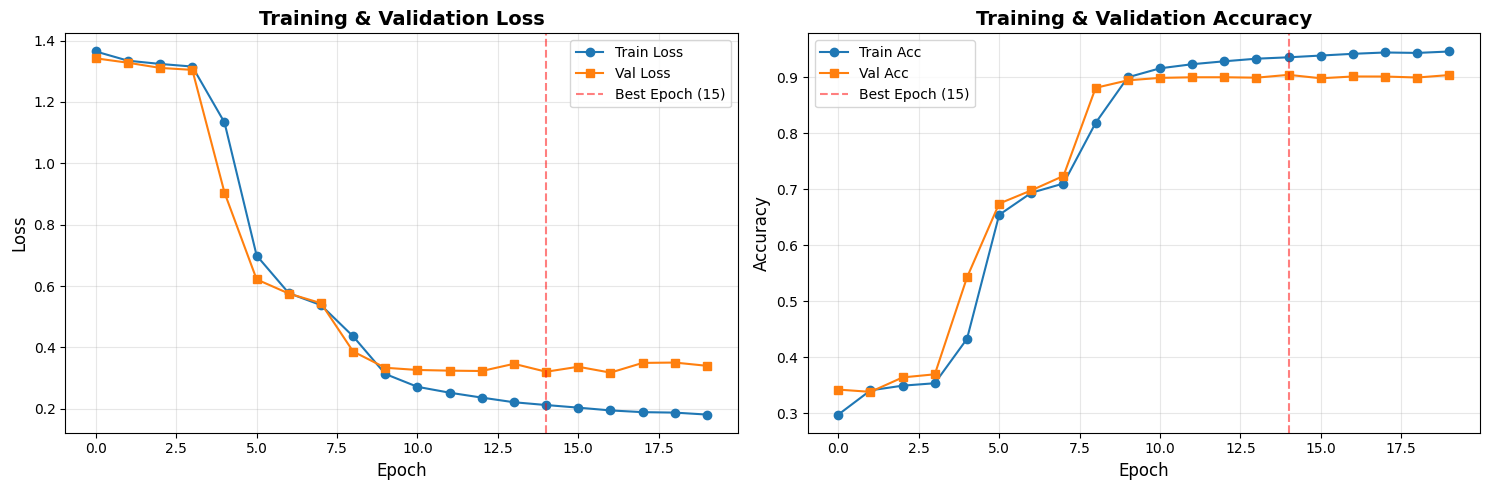


➤ Val loss bắt đầu tăng sau epoch 15 → dấu hiệu overfitting, early stopping đã dừng đúng lúc.


In [ ]:
# Cell 12: Vẽ đồ thị Loss & Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history["train_loss"], label='Train Loss', marker='o')
axes[0].plot(history["val_loss"], label='Val Loss', marker='s')
axes[0].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history["train_acc"], label='Train Acc', marker='o')
axes[1].plot(history["val_acc"], label='Val Acc', marker='s')
axes[1].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n➤ Val loss bắt đầu tăng sau epoch", best_epoch, "→ dấu hiệu overfitting, early stopping đã dừng đúng lúc.")


In [ ]:
# Cell 13: Load best model & Evaluate trên test set
model.load_state_dict(torch.load("best_lstm_news.pth"))
model.eval()

def evaluate_model(model, dataloader, device):
    """Đánh giá model và trả về predictions, labels, probabilities"""
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

test_preds, test_labels_arr, test_probs = evaluate_model(model, test_loader, device)
test_accuracy = accuracy_score(test_labels_arr, test_preds)

print("\n" + "=" * 80)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("=" * 80)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
target_names = [class_names[i] for i in range(NUM_CLASSES)]
report = classification_report(test_labels_arr, test_preds, target_names=target_names, digits=4)
print("\n" + report)

# Per-class analysis
report_dict = classification_report(test_labels_arr, test_preds, target_names=target_names, output_dict=True, digits=4)

class_performance = []
for i, class_name in class_names.items():
    metrics = report_dict[class_name]
    class_performance.append({
        'class': class_name,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1-score'],
        'support': metrics['support']
    })

class_performance_sorted = sorted(class_performance, key=lambda x: x['f1'], reverse=True)

print("\nXếp hạng theo F1-Score:")
print("-" * 80)
for i, perf in enumerate(class_performance_sorted, 1):
    print(f"{i}. {perf['class']:<25} F1: {perf['f1']:.4f} | "
          f"Precision: {perf['precision']:.4f} | Recall: {perf['recall']:.4f}")

best_class = class_performance_sorted[0]
worst_class = class_performance_sorted[-1]

print(f"\n✅ Lớp tốt nhất: {best_class['class']} (F1={best_class['f1']:.4f})")
print(f"❌ Lớp khó nhất: {worst_class['class']} (F1={worst_class['f1']:.4f})")


Evaluating: 100%|██████████| 60/60 [00:02<00:00, 26.19it/s]


ĐÁNH GIÁ TRÊN TEST SET

Test Accuracy: 0.8939 (89.39%)

                      precision    recall  f1-score   support

               World     0.9087    0.8905    0.8995      1900
              Sports     0.9464    0.9658    0.9560      1900
            Business     0.8876    0.8184    0.8516      1900
Science & Technology     0.8363    0.9011    0.8675      1900

            accuracy                         0.8939      7600
           macro avg     0.8947    0.8939    0.8936      7600
        weighted avg     0.8947    0.8939    0.8936      7600


Xếp hạng theo F1-Score:
--------------------------------------------------------------------------------
1. Sports                    F1: 0.9560 | Precision: 0.9464 | Recall: 0.9658
2. World                     F1: 0.8995 | Precision: 0.9087 | Recall: 0.8905
3. Science & Technology      F1: 0.8675 | Precision: 0.8363 | Recall: 0.9011
4. Business                  F1: 0.8516 | Precision: 0.8876 | Recall: 0.8184

✅ Lớp tốt nhất: Sports (F1=0.

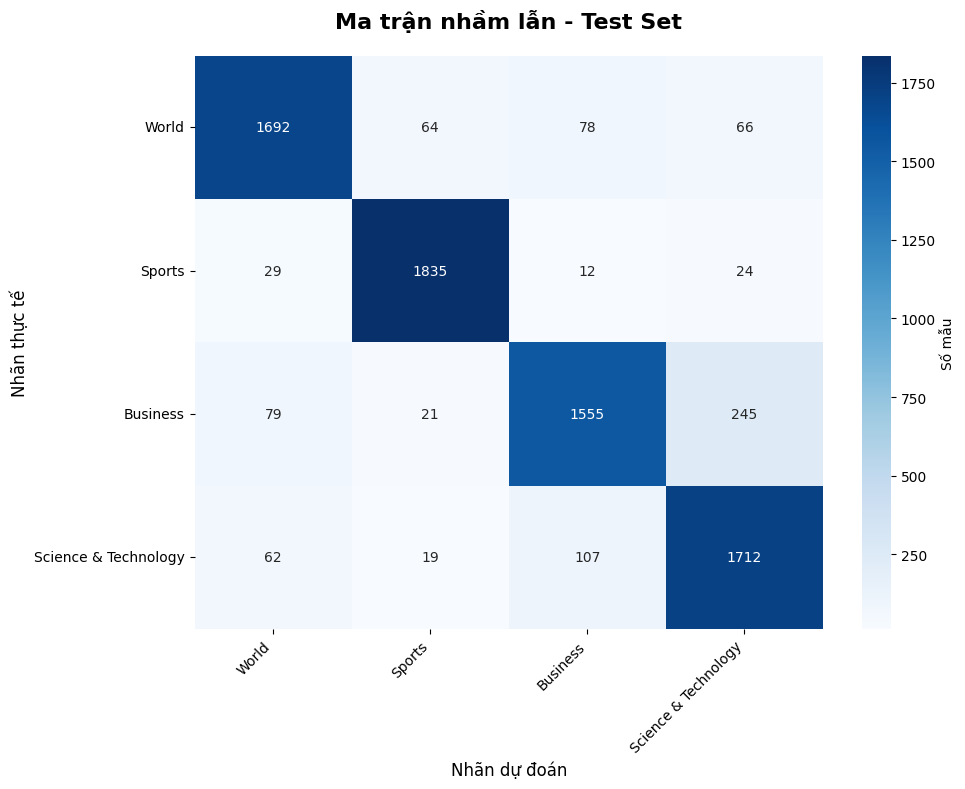


Độ chính xác từng class (từ confusion matrix):
  World                     0.8905 (89.05%)
  Sports                    0.9658 (96.58%)
  Business                  0.8184 (81.84%)
  Science & Technology      0.9011 (90.11%)


In [ ]:
# Cell 14: Confusion Matrix
cm = confusion_matrix(test_labels_arr, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Số mẫu'})
plt.title('Ma trận nhầm lẫn - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nĐộ chính xác từng class (từ confusion matrix):")
for i in range(NUM_CLASSES):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {class_names[i]:<25} {class_acc:.4f} ({class_acc*100:.2f}%)")


In [ ]:
# Cell 15: Sample predictions
np.random.seed(42)
num_samples = 10
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

print("\n" + "=" * 80)
print(f"DỰ ĐOÁN MẪU ({num_samples} mẫu ngẫu nhiên)")
print("=" * 80)

for i, idx in enumerate(sample_indices, 1):
    original_text = test_df.iloc[idx]['description']
    true_label = test_labels_arr[idx]
    pred_label = test_preds[idx]
    probs = test_probs[idx]

    true_class = class_names[true_label]
    pred_class = class_names[pred_label]
    is_correct = "✓" if true_label == pred_label else "✗"

    print(f"\n{'='*80}")
    print(f"Mẫu {i} {is_correct}")
    print(f"{'='*80}")
    print(f"Text: {original_text[:150]}{'...' if len(original_text) > 150 else ''}")
    print(f"\n✅Nhãn thực tế: {true_class}")
    print(f"✅Dự đoán: {pred_class}")
    print(f"\nXác suất dự đoán:")
    for j in range(NUM_CLASSES):
        bar_length = int(probs[j] * 40)
        bar = '█' * bar_length + '░' * (40 - bar_length)
        marker = "→" if j == pred_label else " "
        print(f"  {marker} {class_names[j]:<25} {bar} {probs[j]:.4f}")



DỰ ĐOÁN MẪU (10 mẫu ngẫu nhiên)

Mẫu 1 ✓
Text: This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, entertain ...

✅Nhãn thực tế: Sports
✅Dự đoán: Sports

Xác suất dự đoán:
    World                     ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.0225
  → Sports                    ██████████████████████████████████████░░ 0.9729
    Business                  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.0030
    Science & Technology      ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.0016

Mẫu 2 ✓
Text: Reuters - A funny thing happened on the way to the\Mona Lisa. Visitors to the Louvre museum in Paris, home of the\world's most famous painting, starte...

✅Nhãn thực tế: World
✅Dự đoán: World

Xác suất dự đoán:
  → World                     ██████████████████░░░░░░░░░░░░░░░░░░░░░░ 0.4610
    Sports                    ███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.0775
    Business                  ████░░░░░░░░░░░

In [ ]:
# Cell 16: Phân tích lỗi phân loại
misclassified_indices = np.where(test_preds != test_labels_arr)[0]

print("\n" + "=" * 80)
print("PHÂN TÍCH LỖI PHÂN LOẠI")
print("=" * 80)
print(f"\nTổng số mẫu bị phân loại sai: {len(misclassified_indices)}/{len(test_labels_arr)}")
print(f"Tỷ lệ lỗi: {len(misclassified_indices)/len(test_labels_arr):.4f} ({len(misclassified_indices)/len(test_labels_arr)*100:.2f}%)")

if len(misclassified_indices) > 0:
    num_errors = min(3, len(misclassified_indices))
    error_samples = np.random.choice(misclassified_indices, num_errors, replace=False)

    print(f"\n{num_errors} ví dụ phân loại sai:")

    for i, idx in enumerate(error_samples, 1):
        original_text = test_df.iloc[idx]['description']
        true_label = test_labels_arr[idx]
        pred_label = test_preds[idx]
        probs = test_probs[idx]

        true_class = class_names[true_label]
        pred_class = class_names[pred_label]

        print(f"\n{'='*80}")
        print(f"Lỗi {i}")
        print(f"{'='*80}")
        print(f"Text: {original_text[:200]}")
        print(f"\n❌ Nhãn đúng: {true_class}")
        print(f"🤖 Dự đoán sai: {pred_class} (confidence: {probs[pred_label]:.4f})")
        print(f"\nXác suất các class:")
        for j in range(NUM_CLASSES):
            marker = "→" if j == pred_label else " "
            highlight = "**" if j == true_label else "  "
            print(f"  {marker} {highlight} {class_names[j]:<25} {probs[j]:.4f}")

        if probs[true_label] > 0.15:
            print(f"\n💭 Model có phân vân giữa {true_class} và {pred_class}")
        else:
            print(f"\n💭 Model rất tự tin (sai) về {pred_class}")



PHÂN TÍCH LỖI PHÂN LOẠI

Tổng số mẫu bị phân loại sai: 806/7600
Tỷ lệ lỗi: 0.1061 (10.61%)

3 ví dụ phân loại sai:

Lỗi 1
Text: The N.H.L. appears poised to reject a proposal made by the players union, which included a 24 percent reduction in pay and other concessions but not a hard salary cap.

❌ Nhãn đúng: Sports
🤖 Dự đoán sai: Business (confidence: 0.4560)

Xác suất các class:
       World                     0.1542
    ** Sports                    0.0567
  →    Business                  0.4560
       Science & Technology      0.3331

💭 Model rất tự tin (sai) về Business

Lỗi 2
Text: Sometimes, a piece of soggy cereal is just a piece of soggy cereal. Unless, of course, it bears an uncanny resemblance to history's most beloved extraterrestrial, E.T.

❌ Nhãn đúng: Science & Technology
🤖 Dự đoán sai: World (confidence: 0.4209)

Xác suất các class:
  →    World                     0.4209
       Sports                    0.0726
       Business                  0.0956
    ** Science & Te

In [ ]:
# Cell 17: Tóm tắt kết quả
print("\n" + "=" * 80)
print("TÓM TẮT KẾT QUẢ")
print("=" * 80)

print(f"""
📊 HIỆU NĂNG MODEL:
   • Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)
   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
   • Macro F1-Score: {report_dict['macro avg']['f1-score']:.4f}
   • Weighted F1-Score: {report_dict['weighted avg']['f1-score']:.4f}

🏗️ KIẾN TRÚC:
   • Model: Multi-layer Bidirectional LSTM
   • Layers: Embedding → {NUM_LAYERS}×BiLSTM → FC → Dropout → Output
   • Tổng parameters: {total_params:,}
   • Vocab size: {len(word2idx):,}
   • Sequence length: {MAX_LEN}

⚙️ TRAINING:
   • Epochs trained: {len(history['train_loss'])}
   • Best epoch: {best_epoch}
   • Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})
   • Scheduler: ReduceLROnPlateau
   • Early stopping: patience={PATIENCE}

✅ LỚP TỐT NHẤT: {best_class['class']} (F1={best_class['f1']:.4f})
❌ LỚP KHÓ NHẤT: {worst_class['class']} (F1={worst_class['f1']:.4f})
""")


TÓM TẮT KẾT QUẢ

📊 HIỆU NĂNG MODEL:
   • Best Validation Accuracy: 0.9047 (90.47%)
   • Test Accuracy: 0.8939 (89.39%)
   • Macro F1-Score: 0.8936
   • Weighted F1-Score: 0.8936

🏗️ KIẾN TRÚC:
   • Model: Multi-layer Bidirectional LSTM
   • Layers: Embedding → 1×BiLSTM → FC → Dropout → Output
   • Tổng parameters: 2,501,380
   • Vocab size: 20,000
   • Sequence length: 60

⚙️ TRAINING:
   • Epochs trained: 20
   • Best epoch: 15
   • Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
   • Scheduler: ReduceLROnPlateau
   • Early stopping: patience=5
   
✅ LỚP TỐT NHẤT: Sports (F1=0.9560)
❌ LỚP KHÓ NHẤT: Business (F1=0.8516)



In [ ]:
# Cell 18: Lưu kết quả
import json

results = {
    "model_config": {
        "vocab_size": len(word2idx),
        "embedding_dim": EMBEDDING_DIM,
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "num_classes": NUM_CLASSES,
        "max_len": MAX_LEN,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "dropout_rate": DROPOUT_RATE,
        "num_epochs": len(history['train_loss']),
        "total_parameters": total_params
    },
    "training_history": {
        "train_loss": [float(x) for x in history["train_loss"]],
        "val_loss": [float(x) for x in history["val_loss"]],
        "train_acc": [float(x) for x in history["train_acc"]],
        "val_acc": [float(x) for x in history["val_acc"]]
    },
    "test_results": {
        "test_accuracy": float(test_accuracy),
        "best_val_accuracy": float(best_val_acc),
        "best_epoch": int(best_epoch),
        "macro_f1": float(report_dict['macro avg']['f1-score']),
        "weighted_f1": float(report_dict['weighted avg']['f1-score'])
    },
    "per_class_performance": class_performance
}

with open("training_results.json", "w", encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("\n" + "=" * 80)
print("ĐÃ LƯU KẾT QUẢ")
print("=" * 80)
print("\nCác file đã lưu:")
print("  ✓ best_lstm_news.pth - Trọng số model tốt nhất")
print("  ✓ training_results.json - Lịch sử training và kết quả test")


ĐÃ LƯU KẾT QUẢ

Các file đã lưu:
  ✓ best_lstm_news.pth - Trọng số model tốt nhất
  ✓ training_results.json - Lịch sử training và kết quả test
